In [20]:
import numpy as np
np.random.seed(0)

import keras
from keras.datasets import mnist
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D, Input
from keras.models import Sequential

import matplotlib.pyplot as plt

# To set the color used to display monochrome images.
plt.rcParams['image.cmap'] = 'Blues'

#### Read MNIST data set and do preprocessing

In [16]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_width, img_height = x_train.shape[1], x_train.shape[2]
img_width, img_height 

(28, 28)

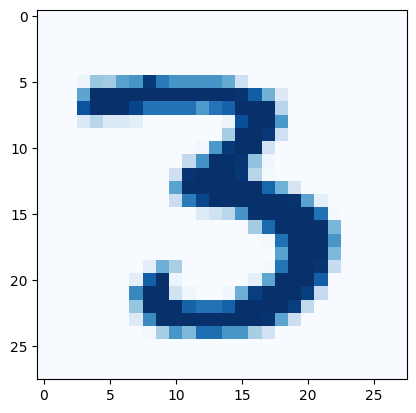

In [17]:
# Reshape the data to fit CNN
# Currently, each image is 28x28 matrix, but CNNs expect a 3D input shape. 
# Need to convert to 3-dimensional tensors
# This means that the whole training set and test set will be reshaped to (#images, 28, 28, 1)
x_train = x_train.reshape(x_train.shape[0], img_width, img_height, 1)
x_test = x_test.reshape(x_test.shape[0], img_width, img_height, 1)

# Normalize the data to be in the range [0, 1] instead of [0, 255]
# CNNs work better with normalized data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Vizalize one of the images in the training set, ex 12th image
plt.imshow(x_train[12,:,:,0]);

In [18]:
# Convert the labels to one-hot encoding
# Necessary for multi-class classification problems in Keras when using categorical crossentropy loss with softmax activation
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

# first instance in the training set is encodes.
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

#### Training the CNN
##### CNNs often uses 2 layers of convolution - first learns simple things like edges and corners and the 2nd learns more complex things like shapes etc. The filters spots patterns and gives a feature map. Pooling is used to summarize the feature map's "most important information". It reduces the size of the feature map. 

##### Like always use early stopping to prevent overfitting 


In [21]:
from tensorflow.keras.callbacks import EarlyStopping

num_classes = 10 # 10 classes for the digits 0-9

model = Sequential([
    Input(shape=(img_width, img_height, 1)),  # Explicit Input layer to prevent warning 
    Conv2D(32, kernel_size=(5,5), strides=(1, 1), activation='relu', input_shape=(img_width, img_height, 1)),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(64, kernel_size=(5,5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(), # Flatten the feature maps to a 1D vector
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax') # Output layer with softmax activation for multi-class classification
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) # roll back to the best-performing model weights on validation data.

# Train the model
model.fit(x_train, y_train,
          batch_size=256,
          epochs=100,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[early_stopping])

Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.8197 - loss: 0.6169 - val_accuracy: 0.9725 - val_loss: 0.0890
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9778 - loss: 0.0742 - val_accuracy: 0.9874 - val_loss: 0.0430
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.9861 - loss: 0.0466 - val_accuracy: 0.9881 - val_loss: 0.0371
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.9896 - loss: 0.0340 - val_accuracy: 0.9887 - val_loss: 0.0321
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.9923 - loss: 0.0257 - val_accuracy: 0.9914 - val_loss: 0.0265
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.9939 - loss: 0.0209 - val_accuracy: 0.9887 - val_loss: 0.0323
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9944 - loss: 0.0183 - val_accuracy: 0.9890 - val_loss: 0.0329
Epoch 8/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9962 - loss: 0

#### Evaluate the model 

In [22]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.025036387145519257
Test accuracy: 0.9921000003814697


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


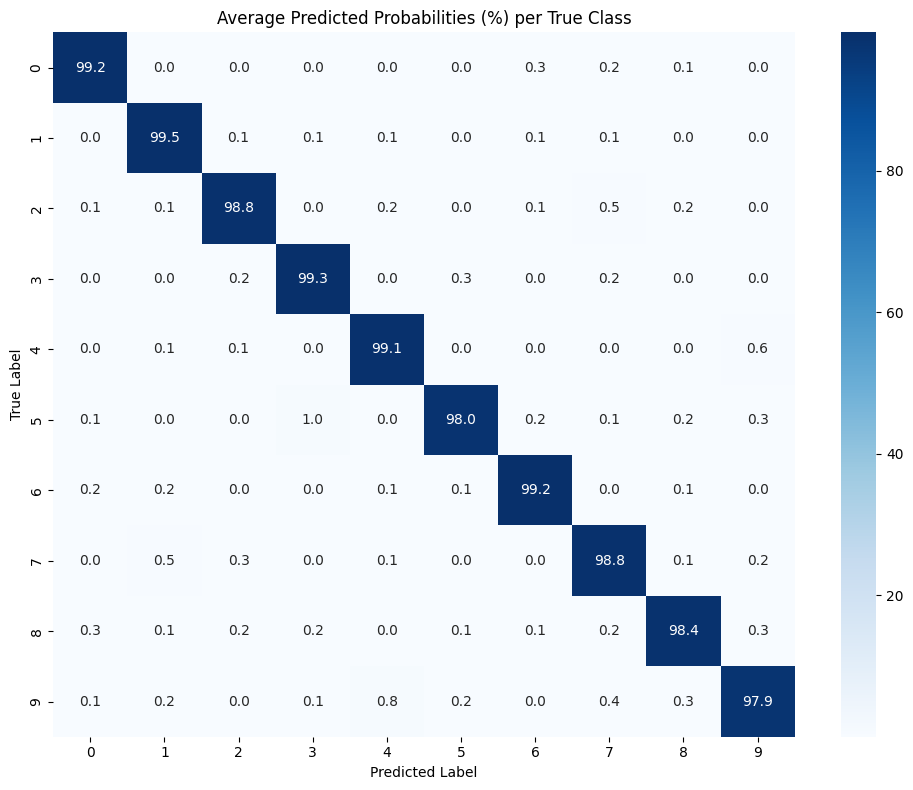

In [ ]:
import seaborn as sns

# Get predictions (probabilities) for the entire test set
y_probs = model.predict(x_test)  # shape: (num_samples, 10)
y_true = np.argmax(y_test, axis=1)  # convert one-hot to integer labels


class_prob_sums = np.zeros((10, 10))  # shape: [true_class, predicted_class]
class_counts = np.zeros(10)


for i in range(len(y_true)):
    true_label = y_true[i]
    class_prob_sums[true_label] += y_probs[i]
    class_counts[true_label] += 1

# Avoid division by zero
class_counts[class_counts == 0] = 1

# Compute average probability distribution for each true class
avg_probs = class_prob_sums / class_counts[:, None]  

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(avg_probs * 100, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=[str(i) for i in range(10)],
            yticklabels=[str(i) for i in range(10)])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Average Predicted Probabilities (%) per True Class")
plt.tight_layout()
plt.show()

##### Inspecting the digit that the model was most confident about, but got wrong

In [29]:
# Gathering misclassified instances in a list
# For each missclassified instance, store the ouput and probability of the gussed class, the probablities of all classes 
# the true dihigit and the image itself
# sorting the list by the output probabilities, so that the first instances in the list are those where the classifier 
# had a (misguided) high confidence in the erroneous predictions.
misclassified = []
for i in range(len(y_true)):
    if y_true[i] != np.argmax(y_probs[i]):
        misclassified.append({
            'output': np.argmax(y_probs[i]),
            'probability': y_probs[i][np.argmax(y_probs[i])],
            'probabilities': y_probs[i],
            'true_digit': y_true[i],
            'image': x_test[i]
        })
# Sort the misclassified instances by the output probability in descending order
misclassified.sort(key=lambda x: x['probability'], reverse=True)
print("Number of missclassifications: ") 
len(misclassified)

Number of missclassifications: 


79

Text(0.5, 1.0, 'Predicted: 6, True: 5')

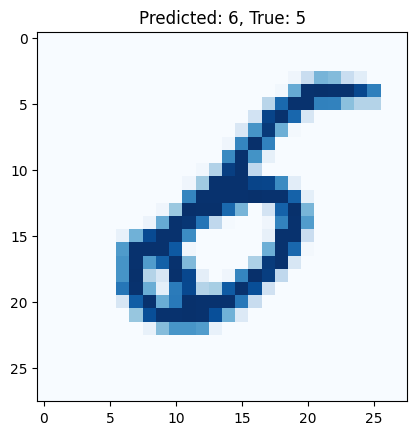

In [30]:
# Here is the digit that the model was most confident about, but got wrong
plt.imshow(misclassified[0]['image'][:, :, 0], cmap='Blues')
plt.title(f"Predicted: {misclassified[0]['output']}, True: {   misclassified[0]['true_digit'] }")

#### Analyzing fit of model 

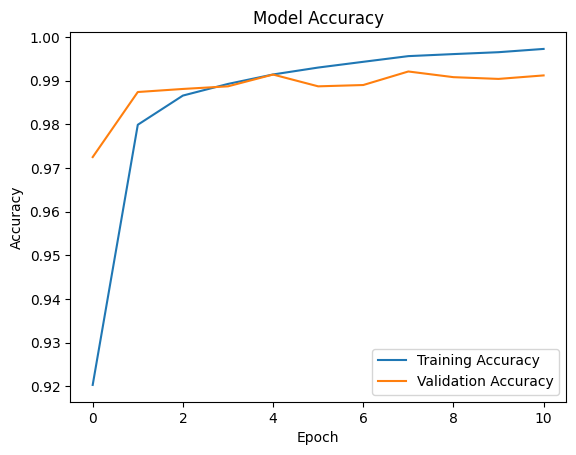

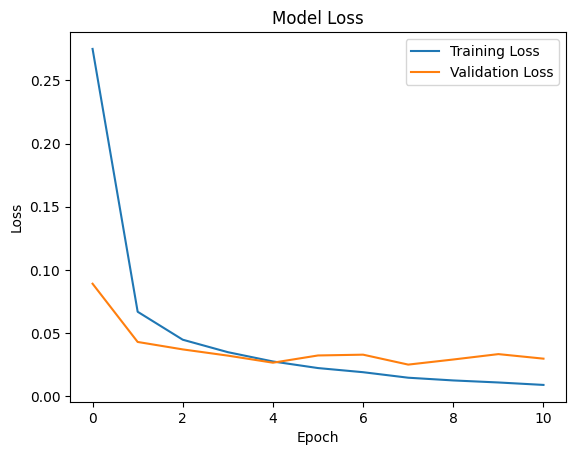

In [41]:
history = model.history.history

# Plot accuracy
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [42]:
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")
print(f"Train Loss: {train_loss:.4f}")
print(f"Test Loss:  {test_loss:.4f}")   

Train Accuracy: 0.9970
Test Accuracy:  0.9921
Train Loss: 0.0108
Test Loss:  0.0250
